In [55]:
import wandb
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
from tabulate import tabulate
from collections import defaultdict
from IPython.display import Markdown, display
import csv
import os
import plotly.express as px
from datetime import datetime


In [130]:
INTERACTIVE_CHARTS=False

In [114]:
def get_results(project:str, entity:str, starts_with="", epoch_start=0,date_before=None, date_after=None):
    api = wandb.Api()
    runs = api.runs(f"{entity}/{project}")
    run_max_metrics = []
    for run in runs:
        if run.name.startswith(starts_with):
            # Skip runs created before the specified date
            created_at = datetime.strptime(run.created_at.rstrip('Z'), "%Y-%m-%dT%H:%M:%S")
            if date_after and created_at < date_after:
                continue

            if date_before and created_at > date_before:
                continue
            seed = run.config.get("seed", "N/A")
            run_history = run.history()
            rank_metrics = "eval/matthews_correlation"

            # Regex pattern to parse run name
            pattern = r"results_(?P<task>[a-zA-Z0-9]+)_(?P<rank_min>[\d.]+)_(?P<rank_max>[\d.]+)_(?P<alpha_min>[\d.]+)_(?P<alpha_max>[\d.]+)_(?P<seed>\d+)_(?P<lr>[\d.eE+-]+)_(?P<rank_avg>[\d.\w]+)"
            match = re.match(pattern, run.name)

            if match and rank_metrics:
                # Extract components from the run name
                task = match.group("task")
                rank_min = float(match.group("rank_min"))
                rank_max = float(match.group("rank_max"))
                alpha_min = float(match.group("alpha_min"))
                alpha_max = float(match.group("alpha_max"))
                seed = int(match.group("seed"))
                rank_allocation_learning_rate = float(match.group("lr"))
                rank_average = None if match.group("rank_avg")=="None" else float(match.group("rank_avg"))

                # Get the overall max of the rank metrics
                overall_max = run.history(keys=[rank_metrics])[rank_metrics][epoch_start:].max() * 100

                # Append parsed data to run_max_metrics
                run_max_metrics.append({
                    "run_name": run.name,
                    "task": task,
                    "rank_min": rank_min,
                    "rank_max": rank_max,
                    "alpha_min": alpha_min,
                    "alpha_max": alpha_max,
                    "rank_allocation_learning_rate": rank_allocation_learning_rate,
                    "rank_average": rank_average,
                    "seed": seed,
                    "overall_max": overall_max
                })
    return sorted(run_max_metrics, key=lambda x: x["overall_max"], reverse=True)

In [95]:
def print_results(run_max_metrics):
    # Create the table header
    table = "| Run Name | Task | Rank Min | Rank Max | Rank Allocation Learning Rate | Rank Average | Alpha Min | Alpha Max | Seed | Overall Max |\n"
    table += "|----------|------|----------|----------|--------------------------------|--------------|-----------|-----------|------|-------------|\n"
    
    # Add rows
    for result in run_max_metrics:
        row = (
            f"| {result['run_name']} "
            f"| {result['task']} "
            f"| {result['rank_min']} "
            f"| {result['rank_max']} "
            f"| {result['rank_allocation_learning_rate']} "
            f"| {result['rank_average']} "
            f"| {result['alpha_min']} "
            f"| {result['alpha_max']} "
            f"| {result['seed']} "
            f"| {result['overall_max']:.2f} |"
        )
        table += row + "\n"
    
    # Render as Markdown
    display(Markdown(table))

In [96]:
def print_stats(run_max_metrics, project):

    # Group runs by parameters excluding seed
    groups = defaultdict(list)
    for run in run_max_metrics:
        key = (
            run['task'],
            run['rank_min'],
            run['rank_max'],
            run['alpha_min'],
            run['alpha_max'],
            run['rank_allocation_learning_rate'],
            run['rank_average']
        )
        groups[key].append(run['overall_max'])

    # Calculate median and std for each group
    group_stats = []
    for key, values in groups.items():
        med = np.median(values)
        std = np.std(values, ddof=1) if len(values) > 1 else 0.0
        group_stats.append({
            'task': key[0],
            'rank_min': key[1],
            'rank_max': key[2],
            'alpha_min': key[3],
            'alpha_max': key[4],
            'lr': key[5],
            'rank_avg': key[6],
            'median': med,
            'std': std
        })

    # Sort by median in descending order
    sorted_group_stats = sorted(group_stats, key=lambda x: x['median'], reverse=True)

    # Prepare table headers and rows
    headers = ["Task", "Rank Min", "Rank Max", "Alpha Min", "Alpha Max", "LR", "Rank Avg", "Median ± Std"]
    rows = []
    for stats in sorted_group_stats:
        med_std_str = f"{stats['median']:.2f} ± {stats['std']:.2f}"
        rows.append([
            stats['task'],
            stats['rank_min'],
            stats['rank_max'],
            stats['alpha_min'],
            stats['alpha_max'],
            stats['lr'],
            stats['rank_avg'],
            med_std_str
        ])

    # Print the table
    markdown_table = tabulate(rows, headers=headers, tablefmt="pipe")
    display(Markdown(markdown_table))
    print()
    csv_filename = "initializations_l_r_results.csv"

    file_exists = os.path.exists(csv_filename)
    if project=='adaptive_rank_allocation': return
    with open(csv_filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        
        if not file_exists:
            writer.writerow(["Project"] + headers)
        
        for row in rows:
            writer.writerow([project] + row)

In [97]:
def plot_results(run_max_metrics: str):
    run_names = [result['run_name'] for result in run_max_metrics]
    overall_max = [result['overall_max'] for result in run_max_metrics]
    learning_rates = [result['rank_allocation_learning_rate'] for result in run_max_metrics]

    # Assign colors based on unique learning rates
    unique_lrs = sorted(set(learning_rates))
    color_map = {lr: plt.cm.tab10(i % 10) for i, lr in enumerate(unique_lrs)}
    colors = [color_map[lr] for lr in learning_rates]

    # Plotting the bar plot
    plt.figure(figsize=(20, 6))
    bar_positions = np.arange(len(run_names))
    plt.bar(bar_positions, overall_max, color=colors, edgecolor='black')

    rank_25_median = 68.55
    rank_25_std = 0.81

    # Add baselines with shading for std
    plt.axhline(rank_25_median, color='black', linestyle='--', label='Baseline for r=25')

    plt.fill_between(bar_positions, rank_25_median - rank_25_std, rank_25_median + rank_25_std, color='black', alpha=0.1, label='Baseline (r=25) ± std')

    # Adding labels and legend
    plt.xticks(bar_positions, bar_positions, rotation=90)
    plt.xlabel('Run Names')
    plt.ylabel('Overall Max')
    plt.title('Overall Max Metrics by Run')

    # Create legend for learning rates
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=f'LR: {lr}', markerfacecolor=color_map[lr], markersize=10) for lr in unique_lrs]
    plt.legend(handles=legend_elements + [plt.Line2D([0], [0], color='red', linestyle='--', label='Baseline for r=20'),
                                           plt.Line2D([0], [0], color='black', linestyle='--', label='Baseline for r=25')],
               loc='upper left', bbox_to_anchor=(1, 1), title="Legend")
    plt.ylim(50, 70)  # Adjust the upper limit if needed

    plt.tight_layout()
    plt.show()



In [98]:
def plot_rank_distribution(project: str, entity: str, run_name: str):
    # Load layer names from CSV
    layer_names_df = pd.read_csv('assets/layer_names.csv')
    
    # Parse component types and layer numbers from layer names
    component_types = []
    layer_nums = []
    for name in layer_names_df['Layer Name']:
        parts = name.split('encoder.layer.')
        after_encoder = parts[1].split('.')
        layer_num = int(after_encoder[0])
        layer_nums.append(layer_num)
        subparts = after_encoder[1:]
        if subparts[0] == 'attention':
            if subparts[1] == 'self':
                component = subparts[2]  # 'query' or 'value'
            elif subparts[1] == 'output':
                component = 'attention_output'
        elif subparts[0] == 'output':
            component = 'output'
        component_types.append(component)
    
    # Define colors for each component type
    component_colors = {
        'query': 'cornflowerblue',    # Muted blue
        'value': 'salmon',            # Soft orange
        'attention_output': 'mediumseagreen',  # Natural green
        'output': 'mediumorchid'      # Muted purple
    }
    
    # Fetch data from wandb
    api = wandb.Api()
    runs = api.runs(f"{entity}/{project}")
    run = next(run for run in runs if run.name == run_name)
    rank_metrics = "eval/matthews_correlation"
    keys = [rank_metrics, '_step']
    history = run.scan_history(keys=keys, page_size=1000)
    history_df = pd.DataFrame(history)
    
    max_correlation = history_df[rank_metrics].max()
    max_step = history_df.loc[history_df[rank_metrics].idxmax(), '_step']
    
    rank_allocation_keys = [f'train/rank_allocation_{i}' for i in range(0, 96)]
    step_data = run.scan_history(keys=['_step'] + rank_allocation_keys, page_size=1000)
    step_data_df = pd.DataFrame(step_data)
    step_values = step_data_df[(step_data_df['_step'] >= max_step - 3)]
    
    # Prepare data for plotting
    values = step_values[rank_allocation_keys].values[0]
    colors = [component_colors[ct] for ct in component_types]
    
    # Create the plot
    plt.figure(figsize=(20, 6))
    plt.bar(range(96), values, color=colors)
    
    # Add vertical lines to separate layers
    for i in range(24):
        x_pos = (i + 1) * 4 - 0.5
        plt.axvline(x=x_pos, color='gray', linestyle='--', linewidth=0.5)
    
    # Set x-ticks to layer numbers
    plt.xticks([i * 4 + 1.5 for i in range(24)], [str(i) for i in range(24)])
    plt.xlabel('Layer Number')
    
    # Create legend
    patches = [mpatches.Patch(color=color, label=label) for label, color in component_colors.items()]
    plt.legend(handles=patches, title='Component Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.title(f"Max Matthews correlation: {max_correlation} at step: {max_step} for run: {run_name}")
    plt.tight_layout()
    plt.show()
    return values, component_types

In [99]:
def plot_rank_allocation_by_component_type(values, component_types):
    """
    Plot a separate line for each component type based on rank allocation values.
    
    Assumes that the input lists are ordered so that every 4 consecutive values correspond to one layer.
    
    Parameters:
        values (list or np.array): Rank allocation values (e.g., length 96 for 24 layers).
        component_types (list of str): Component type for each value (e.g., 'query', 'value', etc.).
    """

    n = len(values)
    # Compute layer numbers assuming each layer has 4 components
    layers = np.array([i // 4 for i in range(n)])

    # Group values by component type
    data_by_type = {}
    for i, comp in enumerate(component_types):
        if comp not in data_by_type:
            data_by_type[comp] = {'layers': [], 'values': []}
        data_by_type[comp]['layers'].append(layers[i])
        data_by_type[comp]['values'].append(values[i])

    # Define colors for each component type (adjust if needed)
    component_colors = {
        'query': 'cornflowerblue',
        'value': 'salmon',
        'attention_output': 'mediumseagreen',
        'output': 'mediumorchid'
    }

    plt.figure(figsize=(20, 6))
    for comp, data in data_by_type.items():
        # Convert lists to numpy arrays and sort by layer number
        x = np.array(data['layers'])
        y = np.array(data['values'])
        sort_idx = np.argsort(x)
        x, y = x[sort_idx], y[sort_idx]
        plt.plot(x, y, marker='o', label=comp, color=component_colors.get(comp, 'black'))

    plt.xlabel("Layer Number")
    plt.ylabel("Rank Allocation Value")
    plt.title("Rank Allocation by Component Type")
    plt.legend(title="Component Type",loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [100]:
def display_project_stats(project:str, entity:str, starts_with="", epoch_start=0 ,date_before=None, date_after=None):
   run_max_metrics=get_results(project=project, entity=entity, starts_with=starts_with, epoch_start=epoch_start, date_after=date_after, date_before=date_before)
   print_stats(run_max_metrics, project)
   plot_results(run_max_metrics)
   best_run = max(run_max_metrics, key=lambda x: x["overall_max"])
   # values, component_types=plot_rank_distribution(project=project, entity=entity, run_name=best_run['run_name'])
   # plot_rank_allocation_by_component_type(values, component_types)
   # # print_results(run_max_metrics)



<!-- ### Uniform initialization (r=20 for every parameter matrix), grid search over learning rates and rank ranges, only 1 run for each learning rate -->

In [127]:
def fetch_and_plot_wandb_runs(entity, project, metric="loss", x_axis="step", interactive=False, num_runs=5, date_before=None, date_after=None):
    """
    Fetches completed runs from a WandB project and plots the specified metric.
    
    :param entity: str, WandB entity (username or team name)
    :param project: str, WandB project name
    :param metric: str, the metric to plot (e.g., "loss", "accuracy")
    :param x_axis: str, the x-axis parameter (default: "step")
    :param interactive: bool, if True, uses Plotly for interactive plots; otherwise, uses Matplotlib.
    :param num_runs: int, optional, number of runs to fetch (default: all runs)
    """
    api = wandb.Api()
    api_runs = api.runs(f"{entity}/{project}")
    runs=[]
    for run in api_runs:
        if num_runs<=0: break
        created_at = datetime.strptime(run.created_at.rstrip('Z'), "%Y-%m-%dT%H:%M:%S")
        if date_after and created_at < date_after:
            continue
                    # Skip runs created before the specified date
        # Skip runs created after the specified date
        if date_before and created_at > date_before:
            continue
        if run.state == "finished":
            runs.append(run)
            num_runs-=1
    
    # Collect run data
    data = []
    for run in runs:
        history = run.history(keys=[x_axis, metric])  # Fetch only necessary metric
        if not history.empty:
            history["run_id"] = run.id
            history["name"] = run.name  # Keep track of run names
            data.append(history)
    
    if not data:
        print("No data found for the specified project and metric.")
        return
    
    # Combine all runs into a single DataFrame
    df = pd.concat(data)
    
    if interactive:
        fig = px.line(df, x=x_axis, y=metric, color="name", title=f"{metric} Over {x_axis}")
        fig.show()
    else:
        plt.figure(figsize=(10, 5))
        for run_id in df["run_id"].unique():
            run_data = df[df["run_id"] == run_id]
            plt.plot(run_data[x_axis], run_data[metric], label=f"Run {run_data['name'].iloc[0]}")
        
        plt.xlabel(x_axis.capitalize())
        plt.ylabel(metric.capitalize())
        plt.title(f"{metric.capitalize()} over {x_axis.capitalize()} (Multiple Runs)")
        plt.legend()
        plt.grid()
        plt.show()


# Smaller to bigger memory on CoLA Report

Initial memory is two times smaller than memory for average rank of 25 for epochs 0-2, then it grows linearly on epochs 3-7 and stabilized at memory that is average for rank of 25 on epochs 8-49.  rank_allocation_weights initialized to random, same scheduling, discrete rank on the last epoch.

Baseline: LoRA-XS with rank 25 - 68.55+-0.81


Script:
```bash
python scripts/run_glue_adaptive.py --target_task cola --wandb_disabled False  --seed $SEED --rank_allocation_lr $rank_allocation_lr --epoch 50  --rank_min 5 --rank_max 30 --memory_start 30000 --memory_end 60000 --epochs_memory_start 3 --epochs_memory_start_to_end 5 --epochs_rank_discrete 1 
```

| Task   |   Rank Min |   Rank Max |   Alpha Min |   Alpha Max |    LR |   Rank Avg | Median ± Std   |
|:-------|-----------:|-----------:|------------:|------------:|------:|-----------:|:---------------|
| cola   |          5 |         30 |         0.5 |           3 | 0.002 |         17 | 53.65 ± 0.45   |
| cola   |          5 |         30 |         0.5 |           3 | 0.02  |         17 | 53.23 ± 0.75   |
| cola   |          5 |         30 |         0.5 |           3 | 0.01  |         17 | 53.12 ± 0.67   |

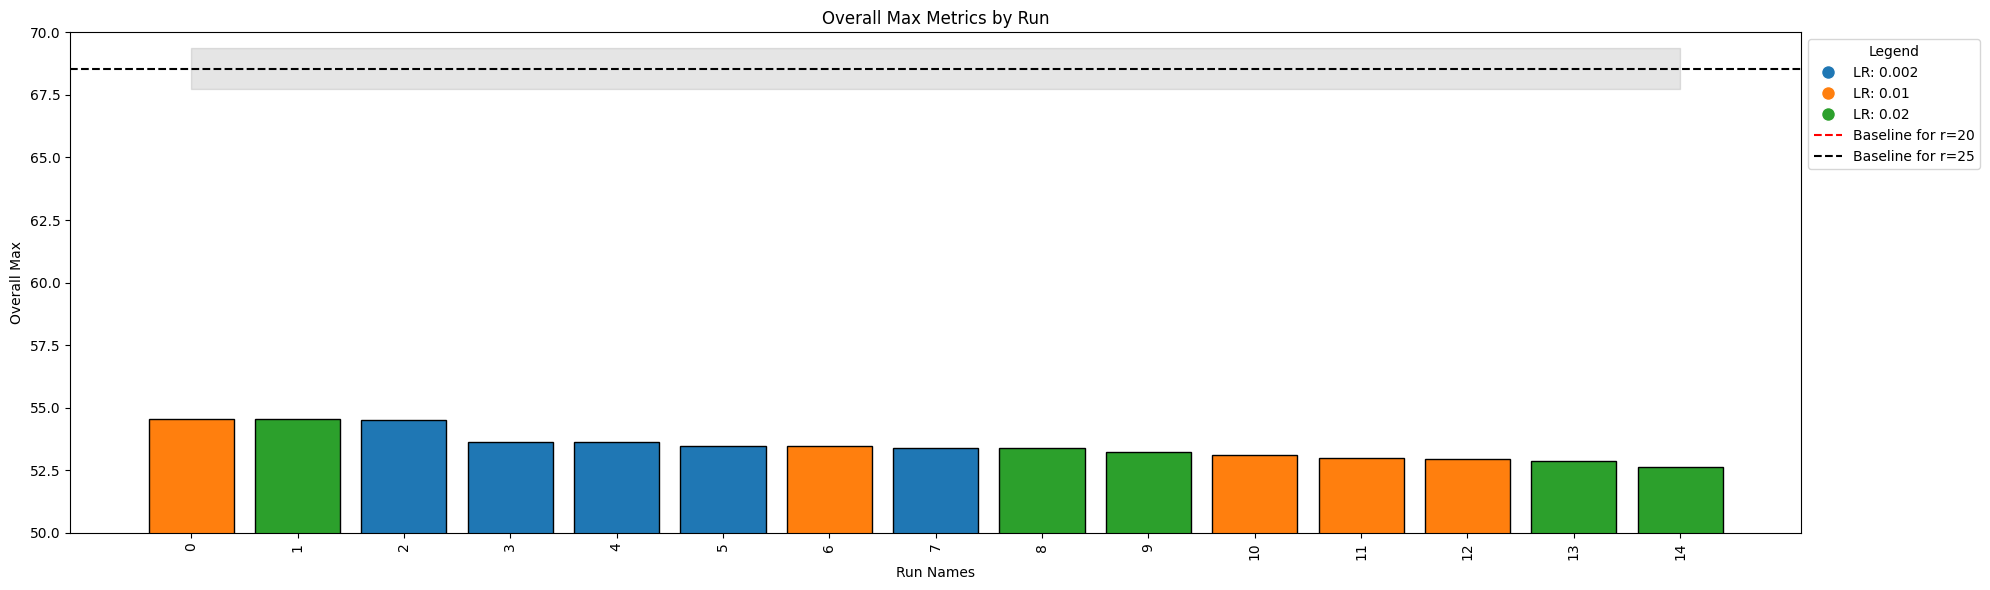

In [78]:
project = "adalora_memory_to_double_memory_3_5"
entity = "mallahova"
date_before=datetime(2025, 4, 14)
display_project_stats(project=project, entity=entity, starts_with="", date_before=date_before )

The problem might be that the model learns the most during the first epochs and it doesn't have the whole memory at the start. Other thing is that the learning rate scheduler is not alligned with memory scheduler - the lerning rate is decreasing when the model has just gotten enough memory to learn.

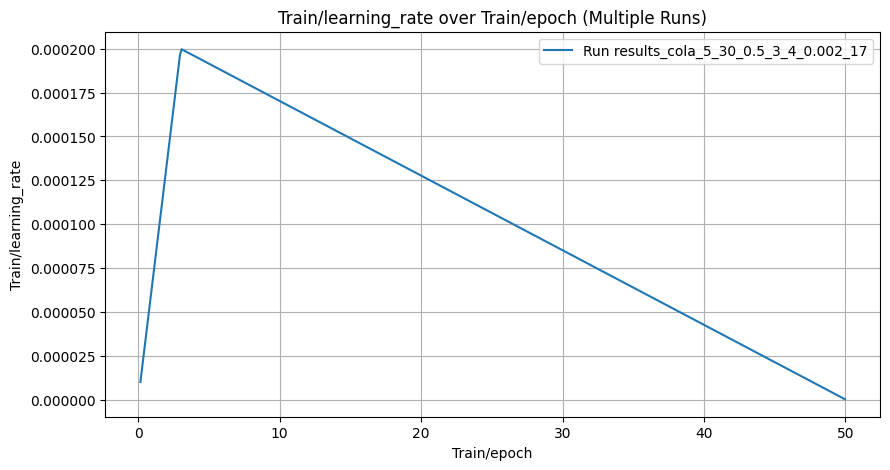

In [131]:
fetch_and_plot_wandb_runs(
    entity="mallahova",
    project="adalora_memory_to_double_memory_3_5",
    metric="train/learning_rate",
    x_axis="train/epoch",
    interactive=INTERACTIVE_CHARTS,
    num_runs=1,
    date_before=date_before
)

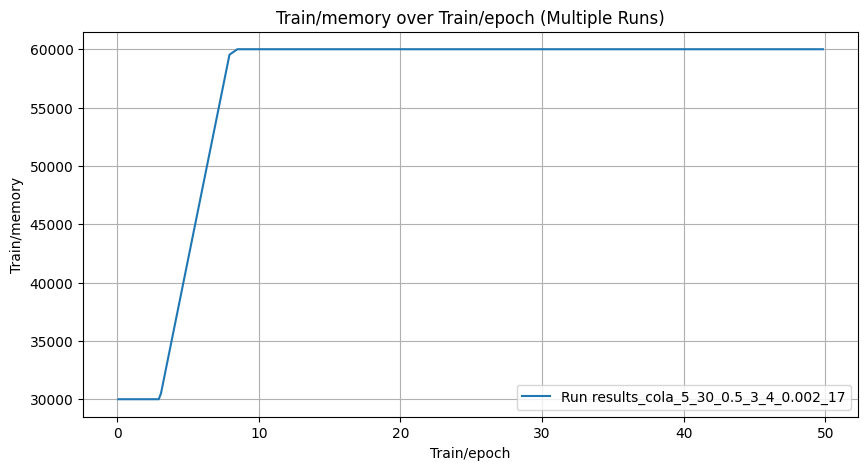

In [132]:
fetch_and_plot_wandb_runs(
    entity="mallahova",
    project="adalora_memory_to_double_memory_3_5",
    metric="train/memory",
    x_axis="train/epoch",
    interactive=INTERACTIVE_CHARTS,
    num_runs=1,
    date_before=date_before

)

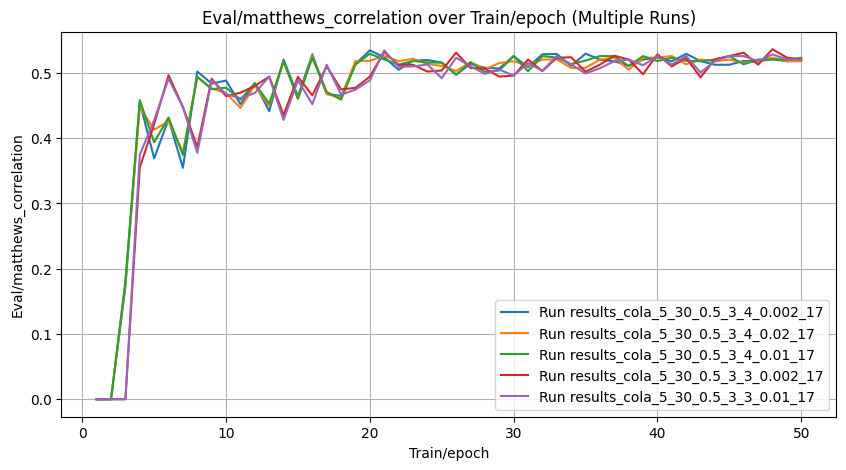

In [133]:
fetch_and_plot_wandb_runs(
    entity="mallahova",
    project="adalora_memory_to_double_memory_3_5",
    metric="eval/matthews_correlation",
    x_axis="train/epoch",
    interactive=INTERACTIVE_CHARTS,
    date_before=date_before

)

## Same setup, but with constant learning rate scheduler
Initial memory is two times smaller than memory for average rank of 25 for epochs 0-2, then it grows linearly on epochs 3-7 and stabilized at memory that is average for rank of 25 on epochs 8-49.  rank_allocation_weights initialized to random, same scheduling, discrete rank on the last epoch.

Baseline: LoRA-XS with rank 25 - 68.55+-0.81

Script:
```bash
python scripts/run_glue_adaptive.py --target_task cola --wandb_disabled False  --seed $SEED --rank_allocation_lr $rank_allocation_lr --epoch 50  --rank_min 5 --rank_max 30 --memory_start 30000 --memory_end 60000 --epochs_memory_start 3 --epochs_memory_start_to_end 5 --epochs_rank_discrete 1 --lr_scheduler constant_schedule
```

| Task   |   Rank Min |   Rank Max |   Alpha Min |   Alpha Max |    LR | Rank Avg   | Median ± Std   |
|:-------|-----------:|-----------:|------------:|------------:|------:|:-----------|:---------------|
| cola   |          5 |         30 |         0.5 |           3 | 0.002 |            | 68.60 ± 1.07   |
| cola   |          5 |         30 |         0.5 |           3 | 0.02  |            | 67.78 ± 1.18   |
| cola   |          5 |         30 |         0.5 |           3 | 0.01  |            | 67.69 ± 1.84   |

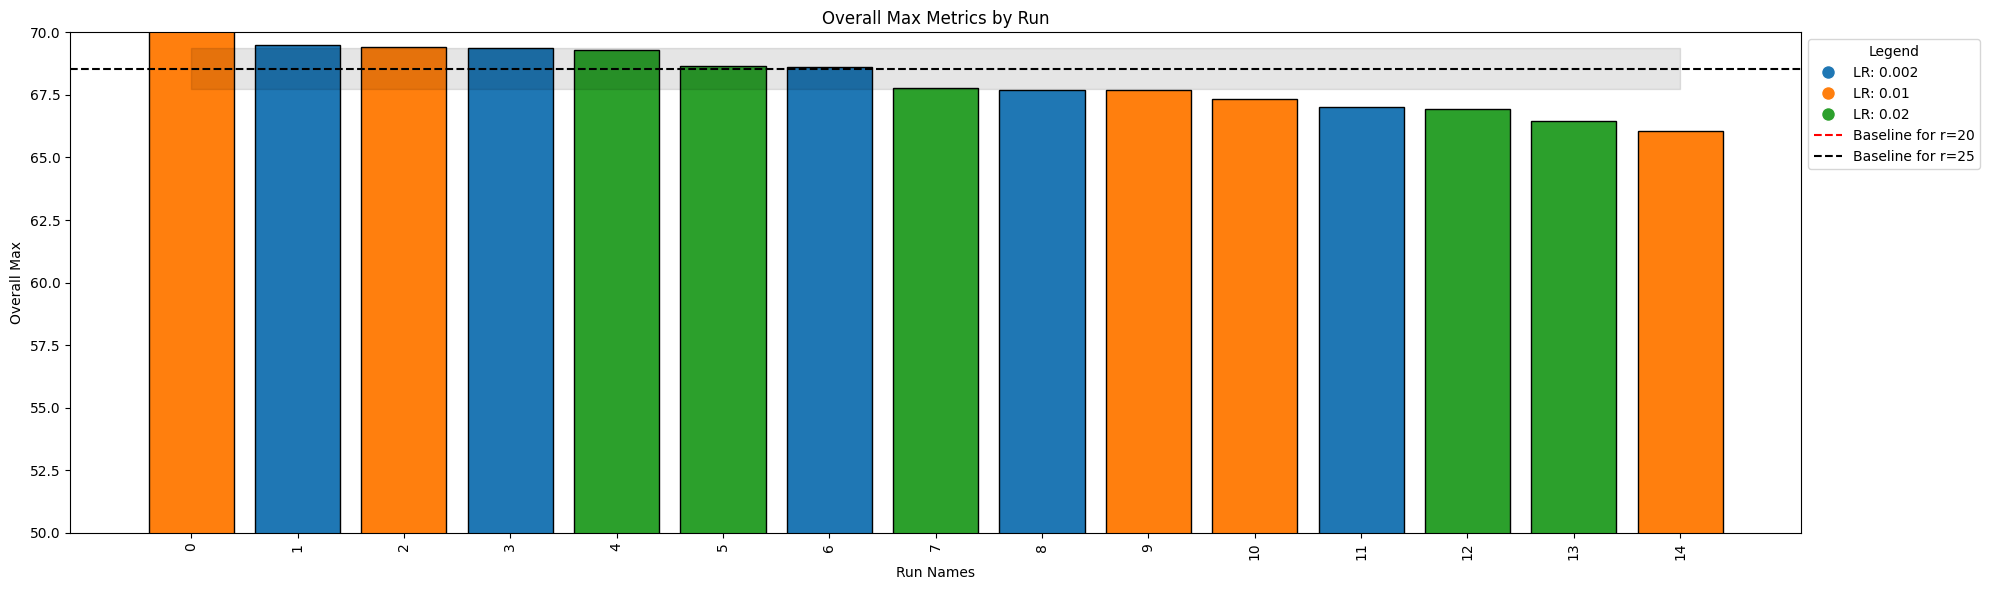

In [115]:
project = "adalora_memory_to_double_memory_3_5"
entity = "mallahova"
date_after=datetime(2025, 4, 14)
display_project_stats(project=project, entity=entity, starts_with="", date_after=date_after )

Slightly above the baseline for LR=0.002

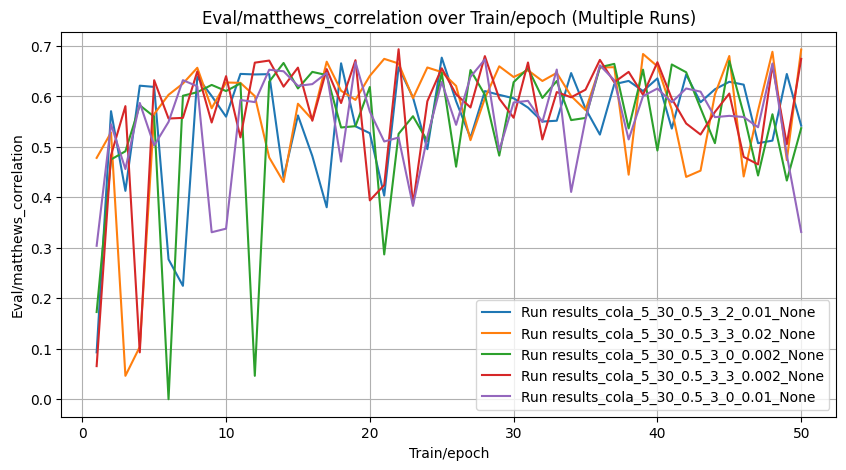

In [134]:
fetch_and_plot_wandb_runs(
    entity="mallahova",
    project="adalora_memory_to_double_memory_3_5",
    metric="eval/matthews_correlation",
    x_axis="train/epoch",
    interactive=INTERACTIVE_CHARTS,
    date_after=date_after
)